<center><h1> Cat And Dog Image Classification Using SVM </h1> </center>

One of the main advantages of using SVMs for image classification is that they can effectively handle high-dimensional data, such as images. Additionally, SVMs are less prone to overfitting than other algorithms such as neural networks.

In machine learning where the model is trained by input data and expected output data.
To create such a model, it is necessary to go through the following phases:

* Import required libraries
* Load the image and convert it to a dataframe.
* separate input features and targets.
* Split train and test value.
* Build and train the model
* Model evaluation.
* Prediction


In [1]:
# extract dataset
from zipfile import ZipFile

dataset_train = "train.zip"
    
with ZipFile(dataset_train, 'r') as zip:
    zip.extractall()

In [2]:
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
from sklearn.model_selection import GridSearchCV
import cv2
import seaborn as sns
import time
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
folder_path = f"Dataset/"
os.makedirs(folder_path, exist_ok=True)

# define path
confusion_image_path = os.path.join(folder_path, 'confusion matrix.png')
classification_file_path = os.path.join(folder_path, 'classification_report.txt')
model_file_path = os.path.join(folder_path, "svm_model.pkl")

# Path dataset
dataset_dir = "Dataset/"
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test1")

In [4]:
# load data, preprocessing data, and labeling
# dog = 1, cat = 0
train_images = os.listdir(train_dir)
features = []
labels = []
image_size = (50, 50)

# Proses train images
for image in tqdm(train_images, desc="Processing Train Images"):
    if image[0:3] == 'cat' :
        label = 0
    else :
        label = 1
    image_read = cv2.imread(train_dir+"/"+image)
    image_resized = cv2.resize(image_read, image_size)
    image_normalized = image_resized / 255.0
    image_flatten = image_normalized.flatten()
    features.append(image_flatten)
    labels.append(label)

Processing Train Images: 100%|██████████| 25000/25000 [00:43<00:00, 575.99it/s]


In [5]:
del train_images

In [6]:
features = np.asarray(features)
labels = np.asarray(labels)

# train test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, random_state=42)

In [7]:
del features
del labels

In [8]:
# PCA, SVM, & Pipeline
n_components = 0.8
pca = PCA(n_components=n_components)
svm = SVC()
pca = PCA(n_components=n_components, random_state=42)
pipeline = Pipeline([
    ('pca', pca),
    ('svm', svm)
])

In [9]:
param_grid = {
    'pca__n_components': [2, 1, 0.9, 0.8],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
}

In [10]:
# Hitung waktu training
start_time = time.time()

grid_search = GridSearchCV(pipeline, param_grid, cv=3, verbose=4)
grid_search.fit(X_train, y_train)

# Hitung waktu training
end_time = time.time()

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END pca__n_components=2, svm__kernel=linear;, score=0.527 total time=  16.8s
[CV 2/3] END pca__n_components=2, svm__kernel=linear;, score=0.533 total time=  15.6s
[CV 3/3] END pca__n_components=2, svm__kernel=linear;, score=0.530 total time=  16.2s
[CV 1/3] END pca__n_components=2, svm__kernel=rbf;, score=0.566 total time=  12.9s
[CV 2/3] END pca__n_components=2, svm__kernel=rbf;, score=0.573 total time=  12.8s
[CV 3/3] END pca__n_components=2, svm__kernel=rbf;, score=0.565 total time=  12.6s
[CV 1/3] END pca__n_components=2, svm__kernel=poly;, score=0.496 total time=  11.2s
[CV 2/3] END pca__n_components=2, svm__kernel=poly;, score=0.512 total time=  11.3s
[CV 3/3] END pca__n_components=2, svm__kernel=poly;, score=0.496 total time=  11.2s
[CV 1/3] END pca__n_components=2, svm__kernel=sigmoid;, score=0.501 total time=  13.1s
[CV 2/3] END pca__n_components=2, svm__kernel=sigmoid;, score=0.509 total time=  12.0s
[CV 3/

In [11]:
del X_train
del y_train

In [12]:
# Mendapatkan model terbaik dan parameter terbaik
best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters: ", best_params)
print("Best Score: ", best_score)

Best Parameters:  {'pca__n_components': 0.9, 'svm__kernel': 'rbf'}
Best Score:  0.6756998783724181


In [13]:
# Evaluation on test dataset
accuracy = best_pipeline.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.6762


In [15]:
y_pred = best_pipeline.predict(X_test)

# classification report
target_names = ['Cat', 'Dog']
classification_rep = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report:\n", classification_rep)

with open(classification_file_path, 'w') as file:
    file.write(classification_rep)

Classification Report:
               precision    recall  f1-score   support

         Cat       0.68      0.69      0.68      2529
         Dog       0.68      0.66      0.67      2471

    accuracy                           0.68      5000
   macro avg       0.68      0.68      0.68      5000
weighted avg       0.68      0.68      0.68      5000



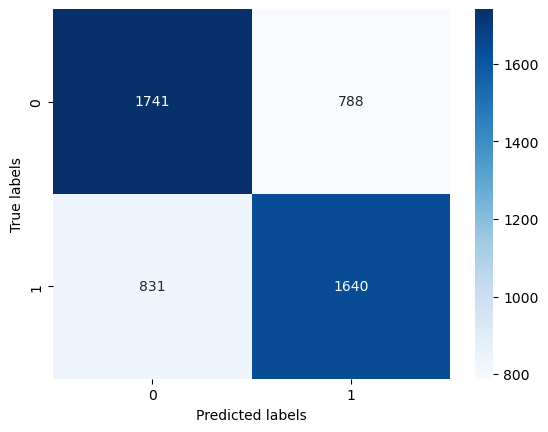

In [16]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig(confusion_image_path)
plt.show()